<a href="https://colab.research.google.com/github/NivedhaBalakrishnan/AgingClock/blob/main/Emotional%20Recognition%20using%20ANN/SpeechEmotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Looking at file name and extract information about the Class Label
import pandas as pd
import glob
from collections import Counter

filenames = glob.glob("/Users/sagar/Downloads/Audio_*_Actors_01-24/Actor_*/*.wav")

    Audio-only files of all actors (01-24) are available as two separate zip files (~200 MB each):

    Speech file (Audio_Speech_Actors_01-24.zip, 215 MB) contains 1440 files: 60 trials per actor x 24 actors = 1440. 
    Song file (Audio_Song_Actors_01-24.zip, 198 MB) contains 1012 files: 44 trials per actor x 23 actors = 1012.
    
    
    Each of the RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 

    Filename identifiers 
        Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
        Vocal channel (01 = speech, 02 = song).
        Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
        Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
        Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
        Repetition (01 = 1st repetition, 02 = 2nd repetition).
        Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

    Filename example: 02-01-06-01-02-01-12.mp4 
        Video-only (02)
        Speech (01)
        Fearful (06)
        Normal intensity (01)
        Statement "dogs" (02)
        1st Repetition (01)
        12th Actor (12)
        Female, as the actor ID number is even.

In [ ]:
emotions_id={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
label_counts = dict(Counter([x.split('/')[-1].split('-')[2] for x in filenames]))
label_counts = {emotions_id[k]:v for k,v in label_counts.items()}
label_counts

{'happy': 376,
 'calm': 376,
 'neutral': 188,
 'fearful': 376,
 'angry': 376,
 'sad': 376,
 'disgust': 192,
 'surprised': 192}

    Note: If we go about creating a classifier for all the 8 emotions we might have to look out for 
          class imballance for the 3 downsampled class (['neutral', 'disgust', 'surprised'])
          The way to take care of them would be:
          1. Not to look at Accuracy as a metric for validation/train
          2. We can go about Tree based algorithms (eg: XGBoost) where we can specify class weights for prediction neutrality.
          
          
          We can also drop those classes and train a classifier to only detect the balanced classes [happy, sad, fearful, angry, calm]

In [ ]:
# Lets visualise how a single sound File looks like and its features
fid = filenames[200]
print(fid)

/Users/sagar/Downloads/Audio_Song_Actors_01-24/Actor_19/03-02-02-02-02-02-19.wav


In [ ]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np

In [ ]:
sf = soundfile.SoundFile(fid)
data = sf.read(dtype="float32")
sample_rate = sf.samplerate

In [ ]:
sf

SoundFile('/Users/sagar/Downloads/Audio_Song_Actors_01-24/Actor_19/03-02-02-02-02-02-19.wav', mode='r', samplerate=48000, channels=1, format='WAV', subtype='PCM_16', endian='FILE')

In [ ]:
data[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
duration = data.shape[0]/sample_rate
duration

4.8048125

In [ ]:
sample_rate

48000

In [ ]:
import IPython.display as ipd
ipd.Audio(fid)

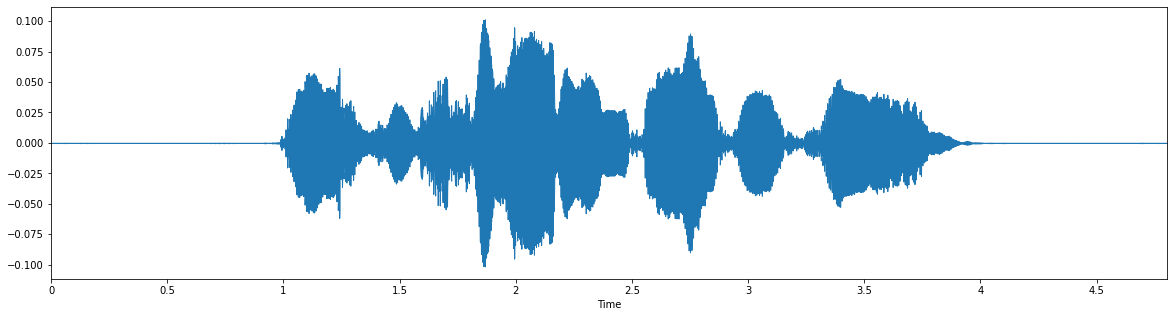

In [ ]:
# Waveplot
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(20, 5))
librosa.display.waveplot(data, sr=sample_rate)

/Users/sagar/envs/ds/lib/python3.8/site-packages/librosa/display.py:822: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn(


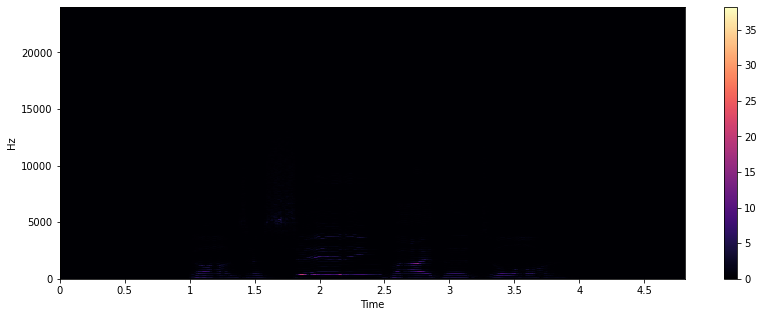

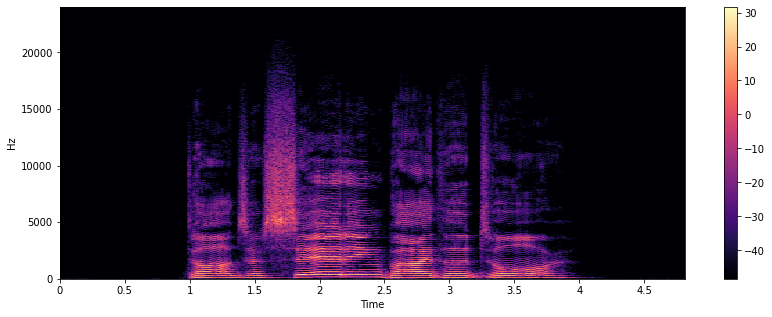

In [ ]:
# Spectrogram
x_stft = librosa.stft(data)
x_db = librosa.amplitude_to_db(abs(x_stft))
plt.figure(figsize=(14, 5))
librosa.display.specshow(x_stft, sr=sample_rate, x_axis='time', y_axis='hz', ) 
plt.colorbar()

plt.figure(figsize=(14, 5))
librosa.display.specshow(x_db, sr=sample_rate, x_axis='time', y_axis='hz', ) 
plt.colorbar()

shape: (128, 451)


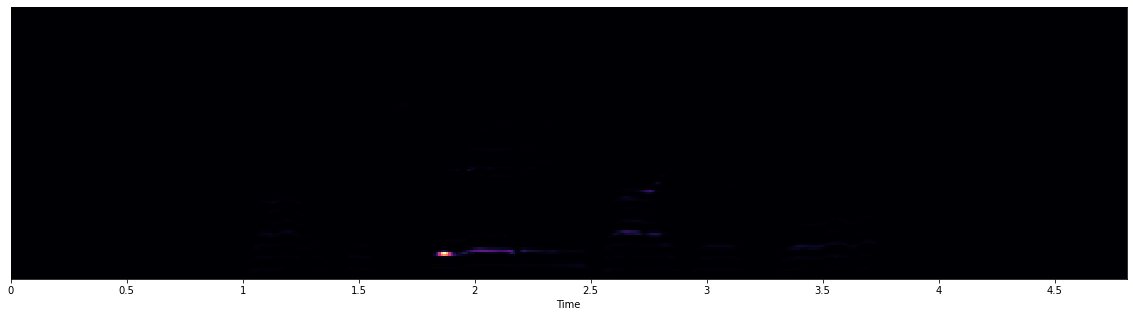

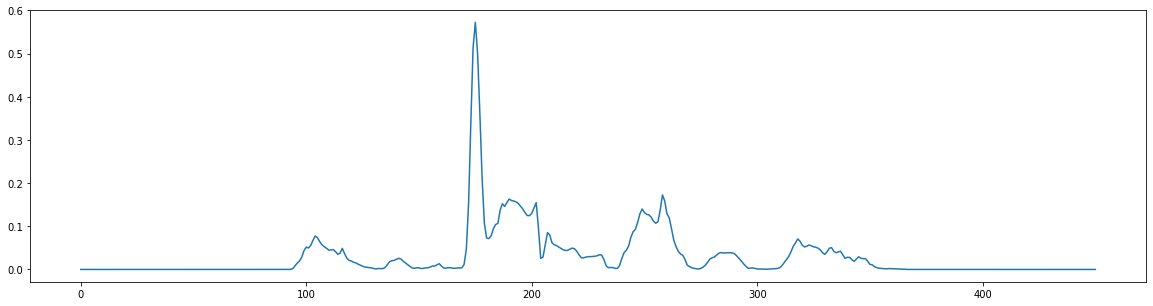

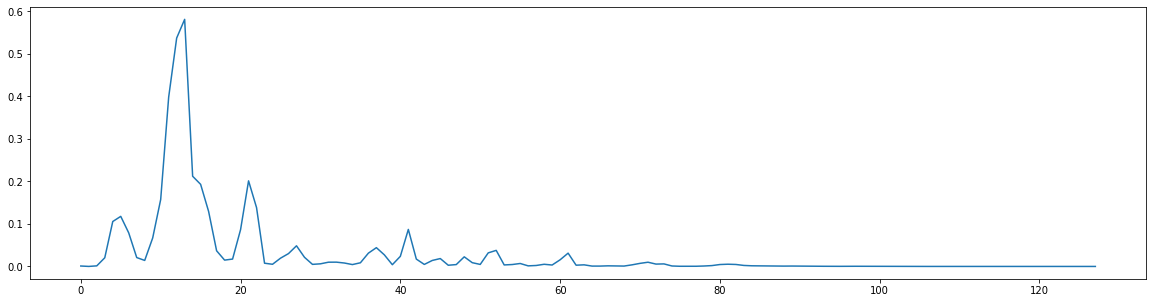

In [ ]:
# mel_scpetrogram
mel_spec = librosa.feature.melspectrogram(data, sr=sample_rate )
print('shape:', mel_spec.shape)
plt.figure(figsize=(20, 5))
librosa.display.specshow(mel_spec, sr=sample_rate, x_axis='time')

plt.figure(figsize=(20, 5))
plt.plot(np.mean(mel_spec, axis=0))

plt.figure(figsize=(20, 5))
plt.plot(np.mean(mel_spec, axis=1))

shape: (13, 451)


/Users/sagar/envs/ds/lib/python3.8/site-packages/librosa/display.py:822: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn(


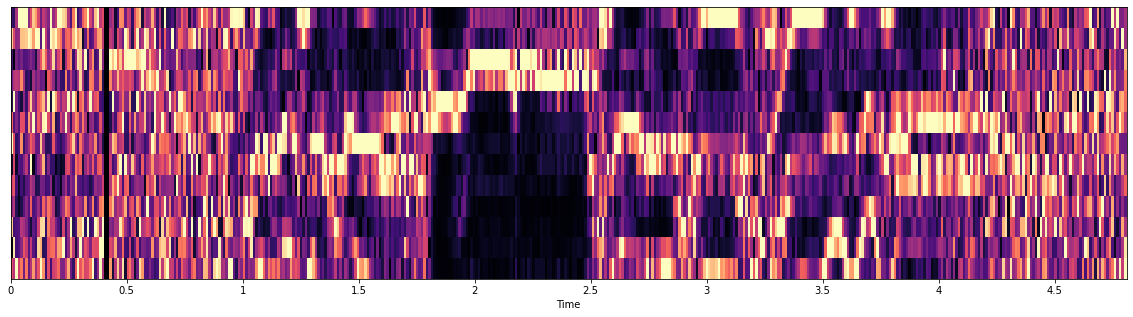

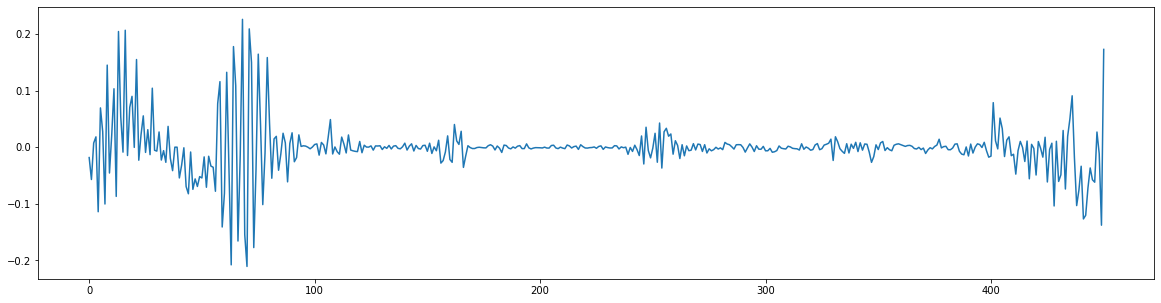

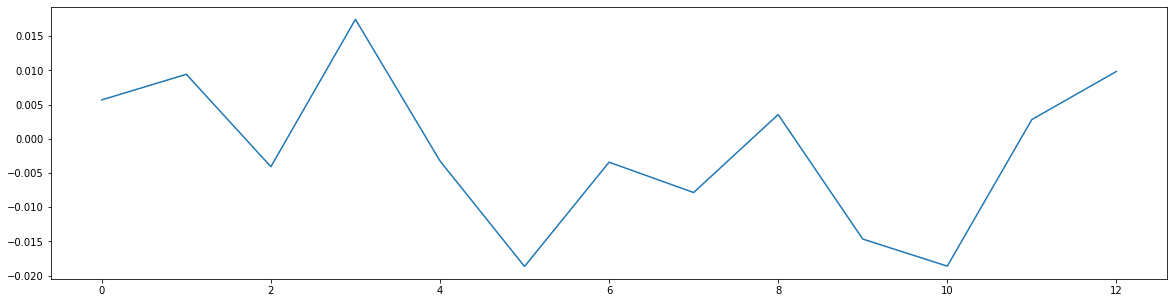

In [ ]:
#chroma sftt (chroma spectogram)
x_stft = librosa.stft(data)
chroma = librosa.feature.chroma_stft(S=x_stft, sr=sample_rate, n_chroma=13)
print('shape:' ,chroma.shape)
plt.figure(figsize=(20, 5))
librosa.display.specshow(chroma, sr=sample_rate, x_axis='time')


plt.figure(figsize=(20, 5))
plt.plot(np.mean(np.real(chroma), axis=0))

plt.figure(figsize=(20, 5))
plt.plot(np.mean(np.real(chroma), axis=1))

shape: (13, 451)


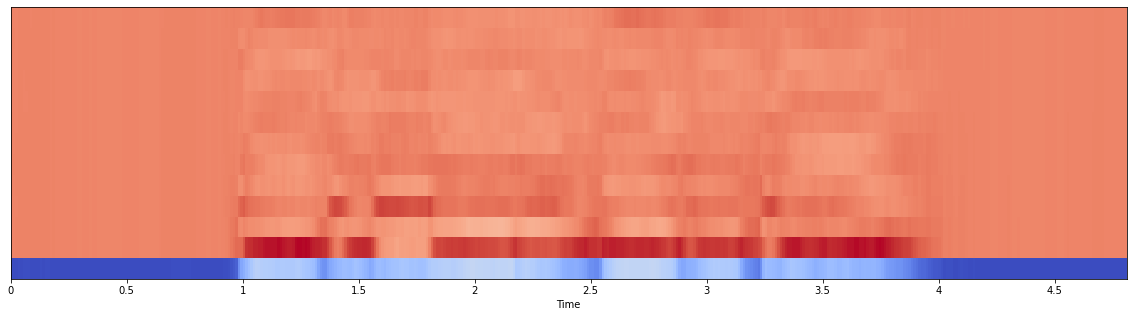

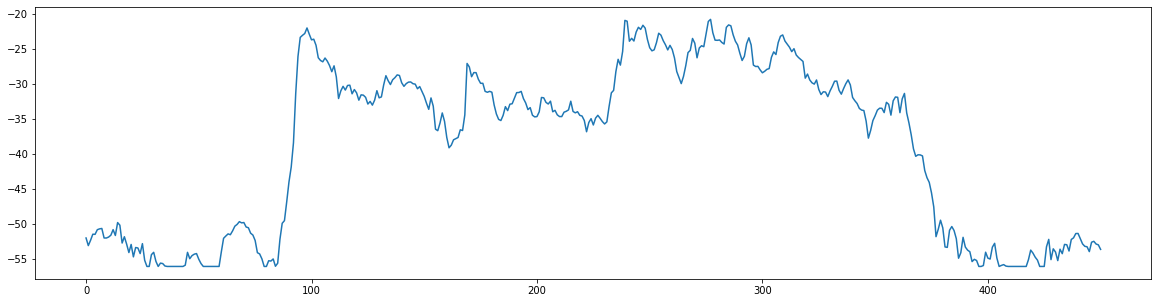

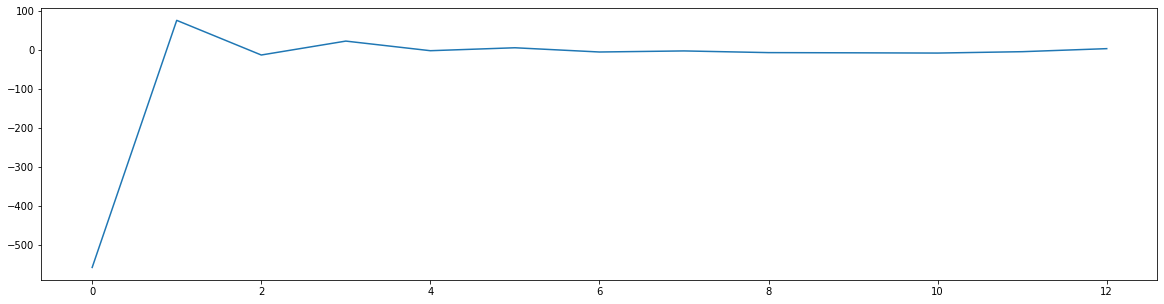

In [ ]:
# MFCC: Mel-Frequency Cepstral Coefficients
mfccs = librosa.feature.mfcc(data, sr=sample_rate, n_mfcc=13)
print('shape:', mfccs.shape)
plt.figure(figsize=(20, 5))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')

plt.figure(figsize=(20, 5))
plt.plot(np.mean(mfccs, axis=0))

plt.figure(figsize=(20, 5))
plt.plot(np.mean(mfccs, axis=1))

Number of Zero Crossing in interval:  8


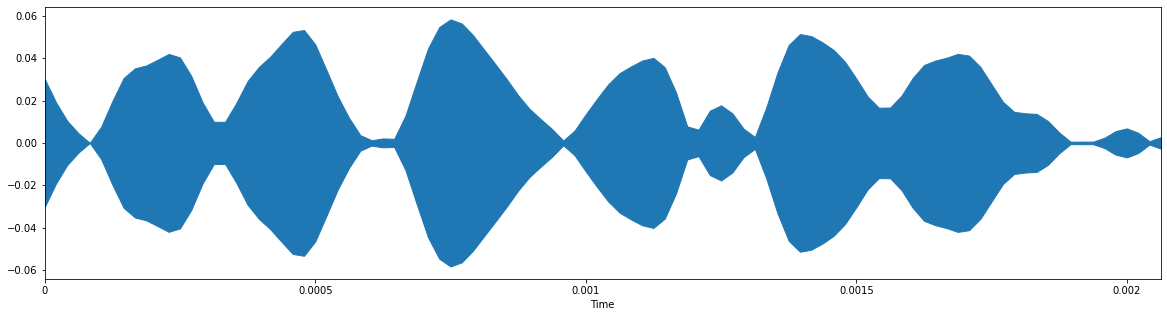

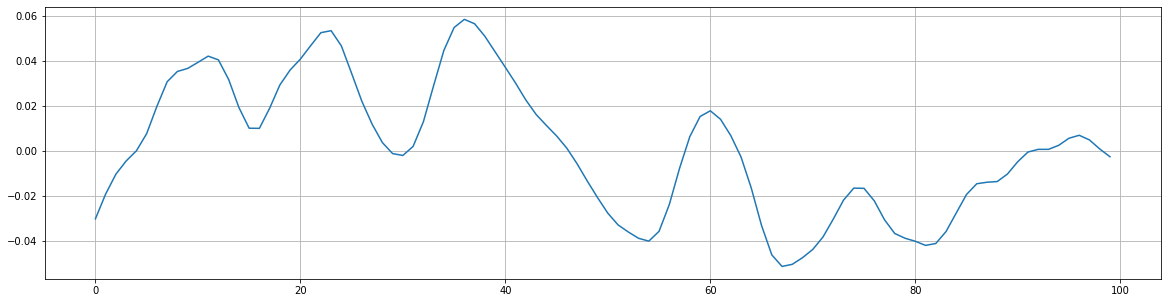

In [ ]:
# Zero Crossings
plt.figure(figsize=(20, 5))
librosa.display.waveplot(data[100000:100100], sr=sample_rate)
plt.figure(figsize=(20, 5))
plt.plot(data[100000:100100])
plt.grid()
zero_crossings = librosa.zero_crossings(data[100000:100100], pad=False)
print('Number of Zero Crossing in interval: ', sum(zero_crossings))

In [ ]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
def extract_feature(file_name, mfcc=True, chroma=True, mel=True, zero_crossing=True):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            stft=np.abs(librosa.stft(X))
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate, n_chroma=24).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        if zero_crossing:
            zc = sum(librosa.zero_crossings(X, pad=False))
            result=np.hstack((result, zc))
    return result

In [ ]:
from collections import Counter

In [ ]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
reverse_emotions = {v:k for k,v in emotions.items()}

# observed_emotions=['calm', 'happy', 'fearful', 'disgust'] // 82
observed_emotions=list(emotions.values())


filenames = glob.glob("/Users/sagar/Downloads/Audio_*_Actors_01-24/Actor_*/*.wav")
id_counts = dict(Counter([x.split('/')[-1].split('-')[2] for x in filenames]))
label_counts = {emotions[k]:v for k,v in id_counts.items()}

In [ ]:
def load_data():
    x,y=[],[]
    for file in filenames:
        try:
            file_name=os.path.basename(file)
            emotion=emotions[file_name.split("-")[2]]
            if emotion not in observed_emotions:
                continue
            feature=extract_feature(file)
            x.append(feature)
            y.append(emotion)
        except Exception as e:
            print(e, file)
    return [np.array(x), y]

In [ ]:
data_x, data_y = load_data()

Invalid shape for monophonic audio: ndim=2, shape=(229029, 2) /Users/sagar/Downloads/Audio_Song_Actors_01-24/Actor_24/03-02-01-01-01-01-24.wav
Invalid shape for monophonic audio: ndim=2, shape=(209809, 2) /Users/sagar/Downloads/Audio_Speech_Actors_01-24/Actor_20/03-01-06-01-01-02-20.wav
Invalid shape for monophonic audio: ndim=2, shape=(166566, 2) /Users/sagar/Downloads/Audio_Speech_Actors_01-24/Actor_20/03-01-03-01-02-01-20.wav
Invalid shape for monophonic audio: ndim=2, shape=(203403, 2) /Users/sagar/Downloads/Audio_Speech_Actors_01-24/Actor_05/03-01-02-01-02-02-05.wav
Invalid shape for monophonic audio: ndim=2, shape=(172972, 2) /Users/sagar/Downloads/Audio_Speech_Actors_01-24/Actor_01/03-01-02-01-01-02-01.wav
Invalid shape for monophonic audio: ndim=2, shape=(156956, 2) /Users/sagar/Downloads/Audio_Speech_Actors_01-24/Actor_01/03-01-08-01-02-02-01.wav


In [ ]:
#Keras-tf model MLP with Dense

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=0.001)

In [ ]:
reverse_emotions

{'neutral': '01',
 'calm': '02',
 'happy': '03',
 'sad': '04',
 'angry': '05',
 'fearful': '06',
 'disgust': '07',
 'surprised': '08'}

In [ ]:
# Data
x_train,x_test,y_train,y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=9)

y_train = to_categorical([int(reverse_emotions[x])-1 for x in y_train])
y_test = to_categorical([int(reverse_emotions[x])-1 for x in y_test])

# Configuration options
feature_vector_length = x_train.shape[1]
num_classes = len(observed_emotions)

input_shape = (feature_vector_length,)

In [ ]:
INPUT_VECTOR(193) : IN(120) : H(80: 50: 30: 20): OP(8)

array([0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [ ]:
# Create the model
np.random.seed(1) # repr


model = Sequential()
model.add(Dense(120, input_shape=input_shape, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(20, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

# Configure the model and start training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop_cb = EarlyStopping(monitor='accuracy', patience=10)

history = model.fit(x_train, y_train, epochs=1500, batch_size=4*16, verbose=1, shuffle=True, validation_split=0.2, callbacks=[early_stop_cb], use_multiprocessing=True, workers=3, )

# Test the model after training
test_results = model.evaluate(x_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - accuracy: {test_results[1]}%')

y_pred = model.predict(x_test)
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

Epoch 1/1500
22/22 [==============================] - 1s 11ms/step - loss: 103.5907 - accuracy: 0.1142 - val_loss: 25.7881 - val_accuracy: 0.0729
Epoch 2/1500
22/22 [==============================] - 0s 3ms/step - loss: 14.9788 - accuracy: 0.1381 - val_loss: 5.7090 - val_accuracy: 0.1691
Epoch 3/1500
22/22 [==============================] - 0s 4ms/step - loss: 5.6084 - accuracy: 0.1620 - val_loss: 6.6970 - val_accuracy: 0.0729
Epoch 4/1500
22/22 [==============================] - 0s 4ms/step - loss: 4.5416 - accuracy: 0.1169 - val_loss: 2.8380 - val_accuracy: 0.1341
Epoch 5/1500
22/22 [==============================] - 0s 4ms/step - loss: 2.6755 - accuracy: 0.1342 - val_loss: 2.1830 - val_accuracy: 0.1137
Epoch 6/1500
22/22 [==============================] - 0s 4ms/step - loss: 2.2042 - accuracy: 0.1539 - val_loss: 3.1231 - val_accuracy: 0.0962
Epoch 7/1500
22/22 [==============================] - 0s 4ms/step - loss: 2.9146 - accuracy: 0.1189 - val_loss: 2.8376 - val_accuracy: 0.1603
E

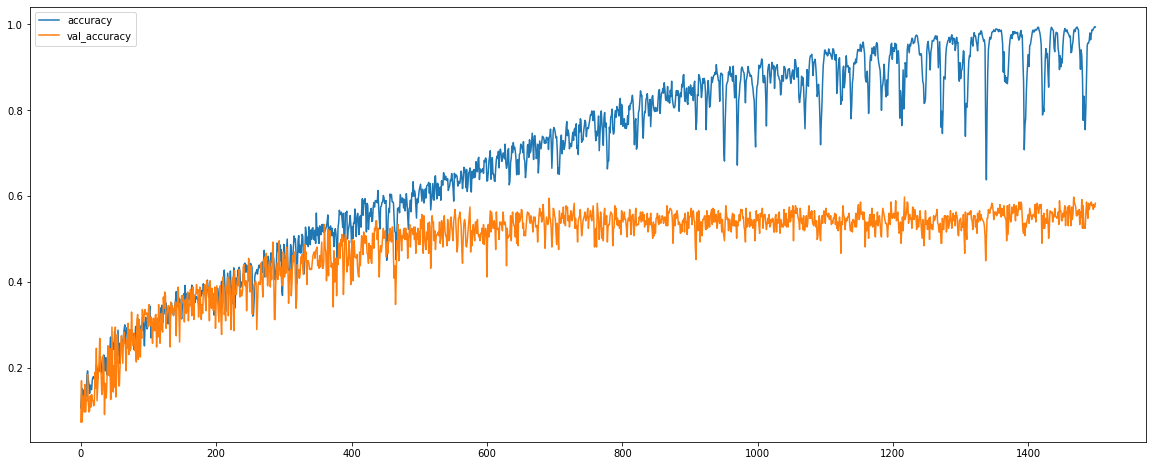

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
# plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['categorical_crossentropy'])
# plt.plot(history.history['val_categorical_crossentropy'])
plt.legend(['accuracy','val_accuracy'])
# plt.legend(['loss' ,'accuracy' ,'val_loss' ,'val_accuracy', 'categorical_crossentropy', 'val_categorical_crossentropy'])

In [ ]:
# Train SKlean Model

x_train,x_test,y_train,y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=9)

# Scikit learn model MLP
model=MLPClassifier(
    alpha=0.01, batch_size=8, epsilon=1e-08,random_state=1,
    hidden_layer_sizes=(120,100,80,50,30,20,), learning_rate='adaptive',
    max_iter=1500, verbose=0, n_iter_no_change=150
)

model.fit(x_train,y_train)

y_pred=model.predict(x_test)

accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

In [ ]:
# Tuning Hyperparametrs

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

model=MLPClassifier(
    batch_size='auto', epsilon=1e-08,random_state=1,learning_rate='adaptive',
    max_iter=100, verbose=0, n_iter_no_change=10
)
parameters = dict(
    alpha=[0.01, 0.001], hidden_layer_sizes=[(120,50,30,), (120,100,)]
)
clf = GridSearchCV(model, parameters)
clf.fit(x_train,y_train)


sorted(clf.cv_results_.keys())

In [ ]:
clf.cv_results_

{'mean_fit_time': array([0.9454318 , 0.58457451, 0.74585972, 0.57192988]),
 'std_fit_time': array([0.3877747 , 0.16304504, 0.33287013, 0.0710734 ]),
 'mean_score_time': array([0.00259414, 0.00240688, 0.00263014, 0.00202088]),
 'std_score_time': array([0.00068728, 0.00045644, 0.00093107, 0.0002458 ]),
 'param_alpha': masked_array(data=[0.01, 0.01, 0.001, 0.001],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[(120, 50, 30), (120, 100), (120, 50, 30), (120, 100)],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.01, 'hidden_layer_sizes': (120, 50, 30)},
  {'alpha': 0.01, 'hidden_layer_sizes': (120, 100)},
  {'alpha': 0.001, 'hidden_layer_sizes': (120, 50, 30)},
  {'alpha': 0.001, 'hidden_layer_sizes': (120, 100)}],
 'split0_test_score': array([0.19533528, 0.14868805, 0.17784257, 0.18658892]),
 'split1_test_score':

In [ ]:
clf.best_params_

{'alpha': 0.001, 'hidden_layer_sizes': (120, 50, 30)}

In [ ]:
clf.best_score_

0.20915383697338585

In [ ]:
clf.best_estimator_

MLPClassifier(alpha=0.001, hidden_layer_sizes=(120, 50, 30),
              learning_rate='adaptive', max_iter=100, random_state=1,
              verbose=0)

In [ ]:
### Infernece from Notebook
python orchestra.py --infer --infer-model-path ./models --infer-file-path '/Users/sagar/Downloads/Audio_Song_Actors_01-24/Actor_19/03-02-01-01-01-02-19.wav'
python orchestra.py --train --framework keras


In [ ]:
from tensorflow.keras.models import load_model
infer_file_path='/Users/sagar/Downloads/Audio_Song_Actors_01-24/Actor_19/03-02-01-01-01-02-19.wav'
infer_model_path = './models'
framework = 'keras' # sklearn
mode='infer' # train


def load_infer_data(filepath):
    ''' 
    Function to load the infernece data from filepath and extract the features the same way we did for training.
    '''
    file_name=os.path.basename(filepath)
    feature=np.array(extract_feature(filepath))
    print(feature.shape)
    # printing the feature shape and reshaping it to a single row vector.
    return feature.reshape(1,-1)


In [ ]:
if framework == 'keras':
    model = load_model(infer_model_path + '/keras')
else:
    with open(infer_model_path + '/sklearn_model.pkl', 'rb') as f:
        model = pickle.load(f)

In [ ]:
model

In [ ]:
data_x = load_infer_data(infer_file_path)

(193,)


In [ ]:
predicted_emotion = model.predict(data_x)

In [ ]:
predicted_emotion

array([[0.09756859, 0.13222097, 0.15684873, 0.14481694, 0.15684742,
        0.15733354, 0.07445011, 0.07991366]], dtype=float32)

In [ ]:
predicted_emotion_index = np.argmax(predicted_emotion)+1

In [ ]:
predicted_emotion_index

6

In [ ]:
print("Predicted Emotion: ", emotions_id['0'+str(predicted_emotion_index)])

Predicted Emotion:  fearful


In [ ]:
emotions_id

{'01': 'neutral',
 '02': 'calm',
 '03': 'happy',
 '04': 'sad',
 '05': 'angry',
 '06': 'fearful',
 '07': 'disgust',
 '08': 'surprised'}